In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

In [2]:
bs = 52
size = 256

In [3]:
path = Path('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/')
path.ls()

[PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/validation'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/train.csv'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/test'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/train'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/sample_submission.csv'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/models'),
 PosixPath('/home/jupyter/HumpbackWhaleIdentification/data_MASKED_256/labels.csv')]

## Competition evaluation metric

In [4]:
def apk(actual, predicted, k=5):
    if len(predicted)>k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def map5kfast(preds, targs, k=10):
    predicted_idxs = preds.sort(descending=True)[1]
    top_5 = predicted_idxs[:, :5]
    scores = torch.zeros(len(preds), k).float()
    for kk in range(k):
        scores[:,kk] = (top_5[:,kk] == targs).float() / float((kk+1))
    return scores.max(dim=1)[0].mean()

def map5(preds,targs):
    if type(preds) is list:
        return torch.cat([map5fast(p, targs, 5).view(1) for p in preds ]).mean()
    return map5kfast(preds,targs, 5)

## Data pipeline

In [5]:
train_df = pd.read_csv(path/"train.csv")
print(train_df.shape)
train_df.head()

(25361, 2)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
labels_count = train_df.Id.value_counts()
labels_count.head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [7]:
train_df.Id.nunique()

5005

In [8]:
train_names = train_df.index.values

In [9]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path, train='train', valid='validation', test='test', ds_tfms=tfms, size=size, bs=bs).normalize(imagenet_stats)

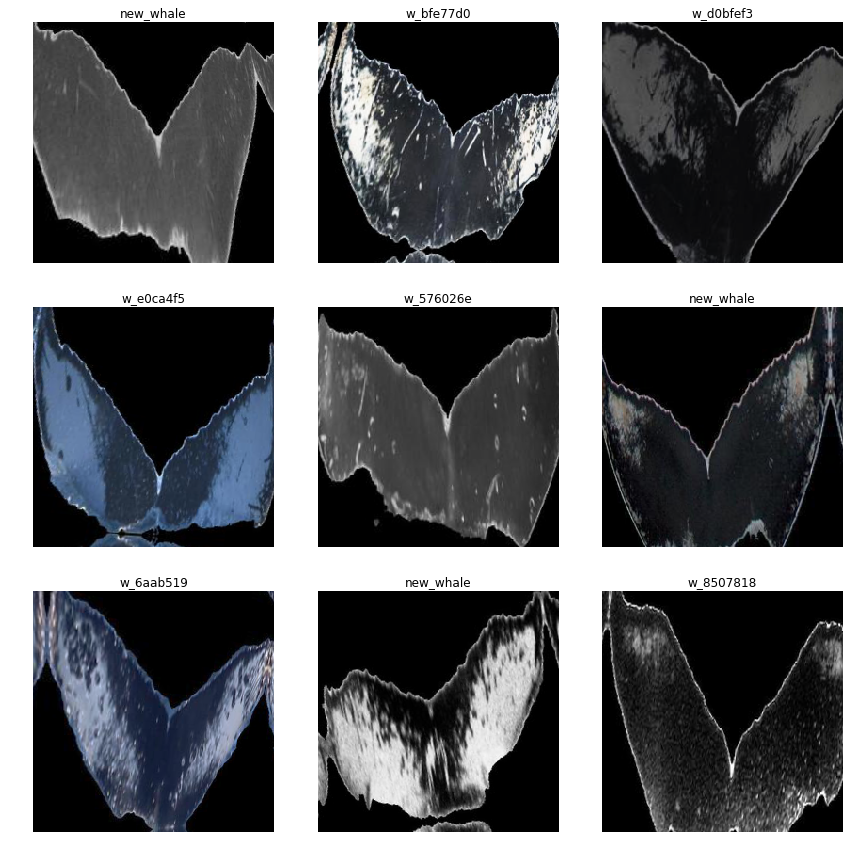

In [10]:
data.show_batch(rows=3, figsize=(12,12))

In [11]:
len(data.classes),data.c

(5005, 5005)

In [12]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

In [ ]:
for i in range(1):
    learn.load('stage-1-resnet50')
    learn.fit_one_cycle(10)
    learn.save('stage-1-resnet50')

In [ ]:
learn.recorder.plot_losses()

# Interpretation

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

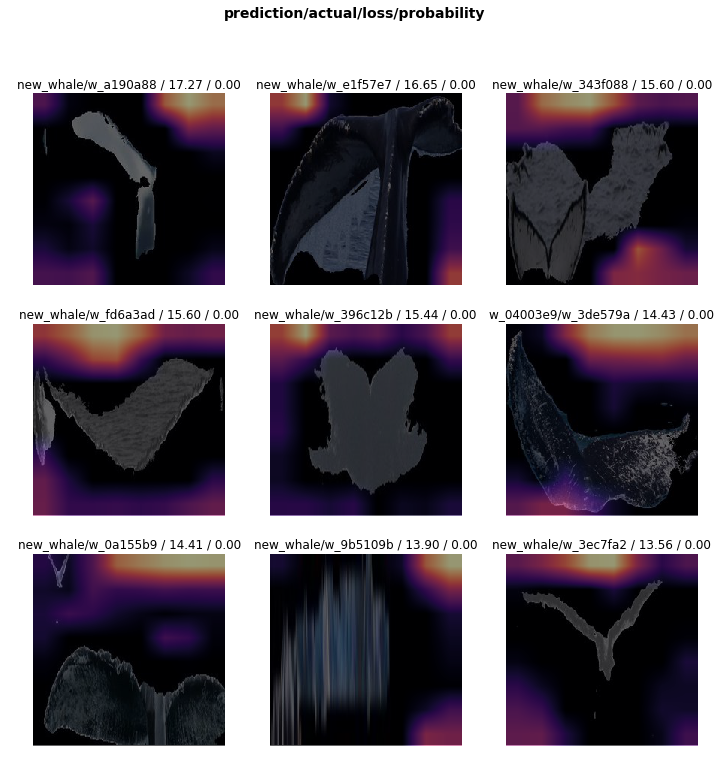

In [32]:
interp.plot_top_losses(9, figsize=(12,12))

# Unfreezing, fine-tuning, and learning rates

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.06E-06


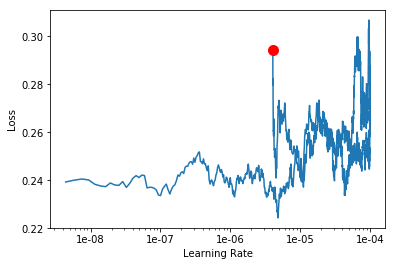

In [24]:
learn.recorder.plot()

In [30]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,map5
1,0.246997,0.520635,0.904507,0.936837
2,0.239075,0.512169,0.905137,0.937766
3,0.231332,0.528910,0.905452,0.937788
4,0.240936,0.520718,0.907028,0.938638
5,0.240775,0.506633,0.908289,0.939390


In [ ]:
learn.load('stage-2-resnet50')
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-6))
learn.save('stage-2-resnet50')

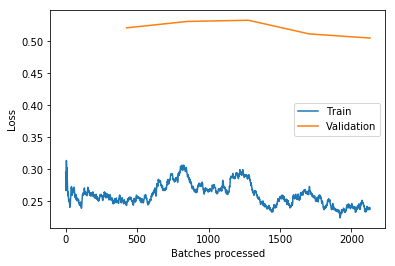

In [25]:
learn.recorder.plot_losses()

## Make submission

In [26]:
preds, targs = learn.get_preds(ds_type=DatasetType.Test)

In [27]:
preds.shape

torch.Size([7960, 5005])

In [28]:
def top_5_pred_labels(preds, classes):
    top_5 = np.argsort(preds.numpy())[:, ::-1][:, :5]
    labels = []
    for item in top_5:
        labels.append(' '.join([classes[whale_id] for whale_id in item]))
    return labels

def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'{name}.csv', index=False)

In [29]:
create_submission(preds, data, "submission")